In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import time
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy import signal, stats

plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16

TIME0 = time.time()

## 1 
Load the time domain data and Fourier transform it.

In [3]:
filename = Path("../strain.npy")
filename.exists()
event_name = "GW170817"
detector_name = "H"
fs = 2**12  # Hz

strain = np.load(filename)
times = np.arange(len(strain)) / fs
dt = times[1] - times[0]
freqs = np.fft.rfftfreq(len(strain), d=dt)
df = freqs[1] - freqs[0]

tukey_window = signal.windows.tukey(M=len(strain), alpha=0.1)
strain_f = np.fft.rfft(strain * tukey_window)

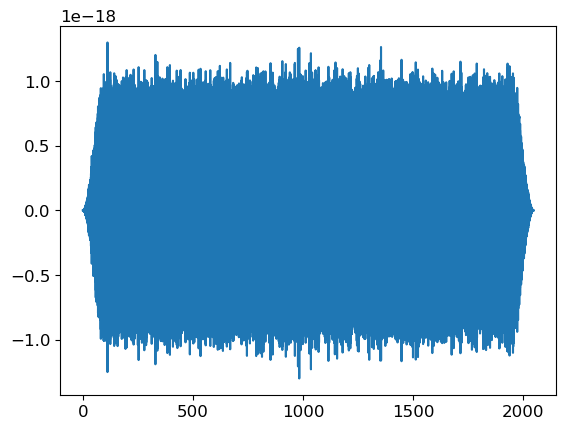

In [4]:
# presenting the time domain signal after tueky widnow
# NOT ASKED FOR IN THE EXAM
fig, ax = plt.subplots()
_ = ax.plot(times, tukey_window * strain)

## 2
Estimate the ASD and create the whitening filter. **Create a log-log plot of the ASD from 20Hz onward**. **Create a log-log plot of the whitening filter from 20Hz onward. Plot the entire whitened strain data**

In [5]:
welch_dict = {
    "x": strain,
    "fs": fs,
    "nperseg": int(64 * fs),
    "noverlap": int(32 * fs),
    "average": "median",
    "scaling": "density",
}

Text(0.5, 1.0, 'ASD')

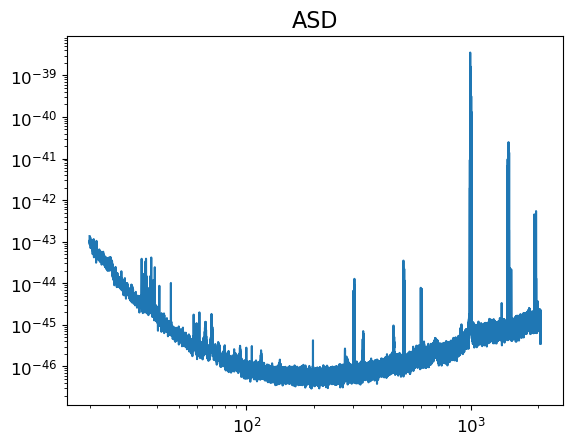

In [6]:
psd_freqs, psd_estimation = signal.welch(**welch_dict)
fmin = 20
asd = np.interp(freqs, psd_freqs, psd_estimation ** (1 / 2))
i = np.searchsorted(psd_freqs, fmin)
plt.loglog(psd_freqs[i:], psd_estimation[i:])
plt.title("ASD")


In [7]:
# Create high-pass filter
highpass_filter = np.zeros(len(freqs))
i1, i2 = np.searchsorted(freqs, (fmin, fmin + 1))
highpass_filter[i1:i2] = np.sin(np.linspace(0, np.pi / 2, i2 - i1)) ** 2
highpass_filter[i2:] = 1.0

whitening_filter_raw = highpass_filter / np.interp(
    x=freqs, xp=psd_freqs, fp=psd_estimation ** (1 / 2)
)

padded_tukey_window = np.pad(
    signal.windows.tukey(M=int(64 * fs), alpha=0.1),
    pad_width=(len(strain) - int(64 * fs)) // 2,
    constant_values=0,
)

whitening_filter = (
    highpass_filter
    * np.fft.rfft(
        np.fft.fftshift(
            padded_tukey_window
            * np.fft.fftshift(np.fft.irfft(whitening_filter_raw))
        )
    ).real
    * np.sqrt(2 * dt)
)


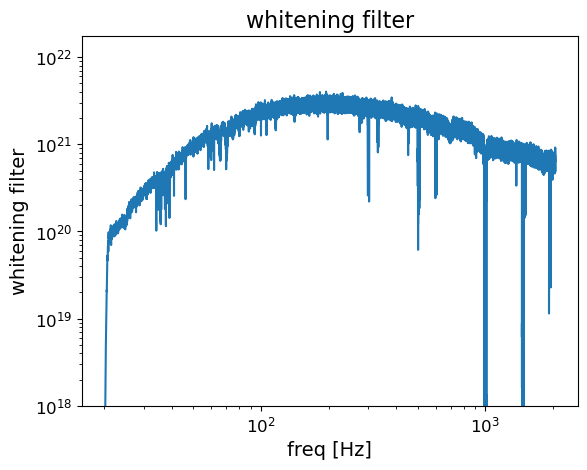

In [8]:
fig, ax = plt.subplots()

_ = ax.loglog(freqs[i1:], np.abs(whitening_filter[i1:]))
_ = ax.set_ylim(1e18)
_ = ax.set_title("whitening filter")
_ = ax.set_xlabel("freq [Hz]")
_ = ax.set_ylabel("whitening filter")

Text(0.5, 0, 'time')

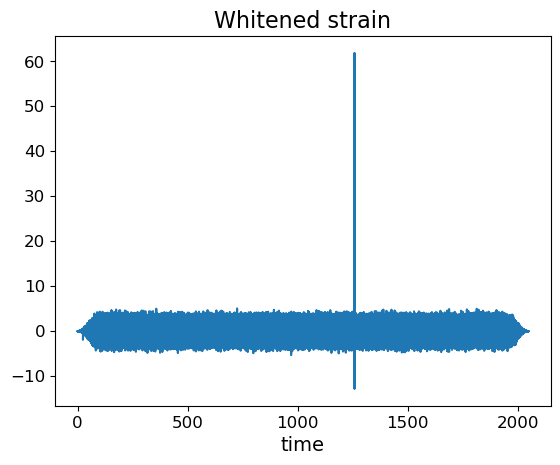

In [9]:
plt.plot(times, np.fft.irfft(strain_f * whitening_filter))
plt.title("Whitened strain")
plt.xlabel("time")

## 3
Create a single template for a search, with arbitrarily selected masses of $m_1=1.5$ and $m_2=1.25$ (in solar masses).  **Plot the time-domain template, such that it is localized in the middle of the time-axis. Fix the plot such that the waveform features are visible**.

In [10]:
import gw_search_functions_SOLVED as gw_search_functions
from importlib import reload

reload(gw_search_functions)
m1 = 1.5
m2 = 1.25

In [11]:
i1 = np.searchsorted(freqs, fmin)
phase = np.zeros_like(freqs)
phase[i1:] = gw_search_functions.masses_to_phases(m1, m2, freqs[i1:])

In [12]:
amp = np.zeros_like(freqs)
amp[i1:] = freqs[i1:] ** (-7 / 6)
h = amp * np.exp(1j * phase)
normalization = np.fft.irfft(np.abs(h * whitening_filter) ** 2)[0] ** (1 / 2)
h /= normalization


Text(0, 0.5, 'h [arb.]')

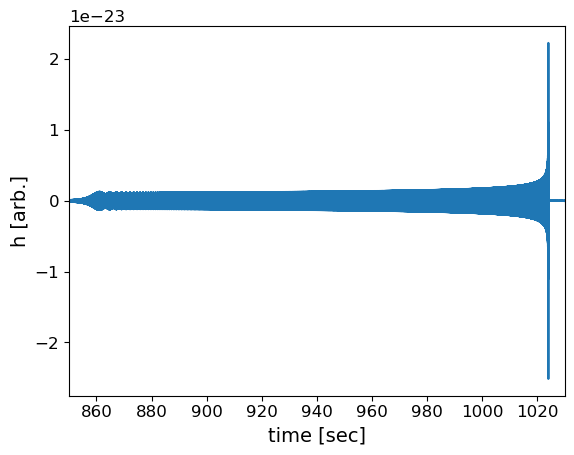

In [13]:
fig, ax = plt.subplots()
ax.plot(times, np.fft.fftshift(np.fft.irfft(h)))
plt.xlim(850, 1030)
ax.set_xlabel("time [sec]")
ax.set_ylabel("h [arb.]")

# 4 
Generate the complex-overlap time-series. **Plot a histogram with the real and imaginary parts of the complex-overlap, in a segment of data without an obvious glitch. Overlay the theoretical predictions**.

In [14]:
whitened_strain_t = np.fft.irfft(strain_f * whitening_filter.conj())

(1250.0, 1260.0)

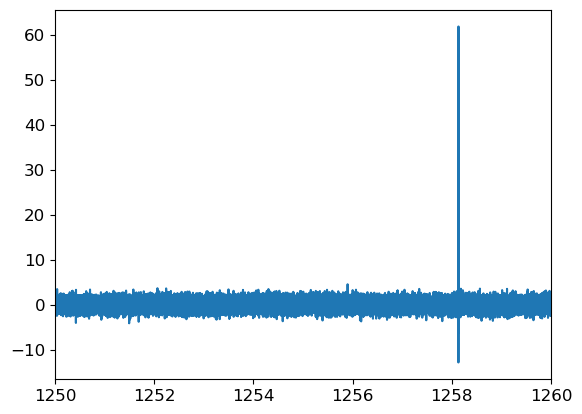

In [15]:
# zoom on glitch, to see where not to use the overlap timeseries
plt.plot(times, whitened_strain_t)
plt.xlim(1250, 1260)

In [16]:
z_cos = np.fft.irfft(
    (strain_f * whitening_filter) * (h * whitening_filter).conj()
)
z_sin = np.fft.irfft(
    (strain_f * whitening_filter) * (h * whitening_filter).conj() * 1j
)
z = z_cos + 1j * z_sin
snr2 = np.abs(z) ** 2

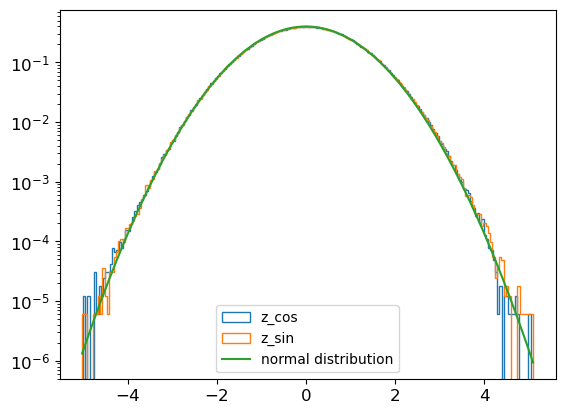

In [17]:
# indices without a glitch
t_start = 200
t_end = 1000
tslice = slice(*np.searchsorted(times, (t_start, t_end)))
# keywords for the histogram
hist_kwargs = {"bins": 200, "density": True, "log": True, "histtype": "step"}
# create 2 histograms
counts, edges, patches = plt.hist(z_cos[tslice], **hist_kwargs, label="z_cos")
counts, edges, patches = plt.hist(z_sin[tslice], **hist_kwargs, label="z_sin")
# overlay normal distribution with mu=0 and sigma=1
plt.plot(edges, stats.norm().pdf(edges), label="normal distribution")
plt.legend(loc="lower center")

# 5

Create the ${\rm SNR}^2$ time series.


To verify your result, use the estimated ASD to draw mock data without a GW
transient. Create the same ${\rm SNR}^2$ time-series on this data. **On the same figure, plot
the histograms of the ${\rm SNR}^2$ of the real data and of the mock data. Overlay the
theoretical prediction**.

In [18]:
# split the variance equally between the real and imaginary components of strain_f
mock_strain_f = [1, 1j] @ stats.norm(scale=asd / np.sqrt(2)).rvs(
    size=(2, len(freqs))
)
# multiply by a factor that relates to the duraion
mock_strain_f *= len(times) / 64

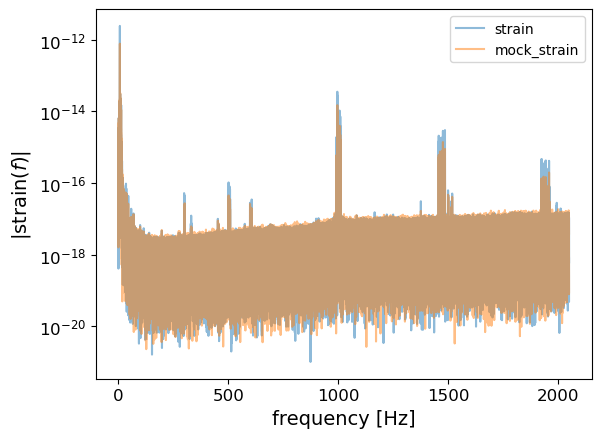

In [19]:
plt.semilogy(freqs, np.abs(strain_f), alpha=0.5, label="strain")
plt.semilogy(freqs, np.abs(mock_strain_f), alpha=0.5, label="mock_strain")
plt.ylabel(r"$|{\rm strain}(f)|$")
plt.xlabel("frequency [Hz]")
plt.legend()

In [20]:
# calculate the SNR^2 for the mock data
mock_snr2 = (
    np.abs(
        np.fft.irfft(
            (mock_strain_f * whitening_filter) * (h * whitening_filter).conj()
        )
        + 1j
        * np.fft.irfft(
            (mock_strain_f * whitening_filter)
            * (h * whitening_filter).conj()
            * 1j
        )
    )
    ** 2
)

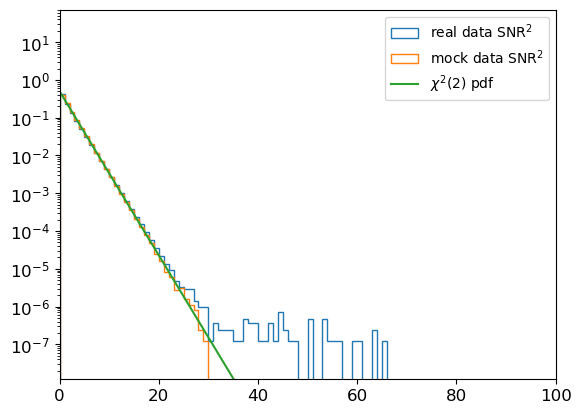

In [21]:
hist_kwargs = {
    "histtype": "step",
    "density": True,
    "log": True,
    "bins": range(200),
}

counts, edges, patches = plt.hist(
    snr2, **hist_kwargs, label=r"real data SNR$^2$"
)
counts, edges, pathes = plt.hist(
    mock_snr2, **hist_kwargs, label=r"mock data SNR$^2$"
)
plt.plot(edges, stats.chi2(df=2).pdf(edges), label=r"$\chi^2(2)$ pdf")
# focus on interesting portion of the histogram
plt.xlim(0, 100)
plt.ylim(1 / np.diff(edges).mean() / len(snr2) / 10)
plt.legend()

# 6

Create a test-statistic to detect glitches. Use it to remove glitches from the ${\rm SNR}^2$ timeseries.
**Plot the cleaned ${\rm SNR}^{2}$ timeseries histogram. Overlay the theoretical prediction**.



In [22]:
# find f_bar = where the cumulative SNR2 is equal half the overall SNR2
frac_snr2 = np.cumsum(np.abs(h * whitening_filter) ** 2)
frac_snr2 /= frac_snr2[-1]
i_fbar = np.searchsorted(frac_snr2, 0.5)

In [23]:
# create the the low and high frequencies templates
h_low, h_high = np.zeros((2, len(freqs)), dtype=complex)
# normalize them so each has norm 1
h_low[:i_fbar] = h[:i_fbar] * np.sqrt(2)
h_high[i_fbar:] = h[i_fbar:] * np.sqrt(2)

In [24]:
# check their normalization
print(
    "<h|h> = ",
    np.fft.irfft((h * whitening_filter) * (h * whitening_filter).conj())[0]
    ** (1 / 2),
)
print(
    "<h_low | h_low> = ",
    np.fft.irfft(
        (h_low * whitening_filter) * (h_low * whitening_filter).conj()
    )[0]
    ** (1 / 2),
)
print(
    "<h_high | h_high> = ",
    np.fft.irfft(
        (h_high * whitening_filter) * (h_high * whitening_filter).conj()
    )[0]
    ** (1 / 2),
)
print(
    "<h_low| h_high> = ",
    np.fft.irfft(
        (h_high * whitening_filter) * (h_low * whitening_filter).conj()
    )[0]
    ** (1 / 2),
)

<h|h> =  1.0
<h_low | h_low> =  0.9999988070139066
<h_high | h_high> =  1.0000011929846702
<h_low| h_high> =  0.0


In [25]:
z_low, z_high = [
    (
        np.fft.irfft(
            strain_f * whitening_filter * (x * whitening_filter).conj()
        )
        + 1j
        * np.fft.irfft(
            strain_f * whitening_filter * (x * whitening_filter).conj() * 1j
        )
    )
    for x in [h_low, h_high]
]

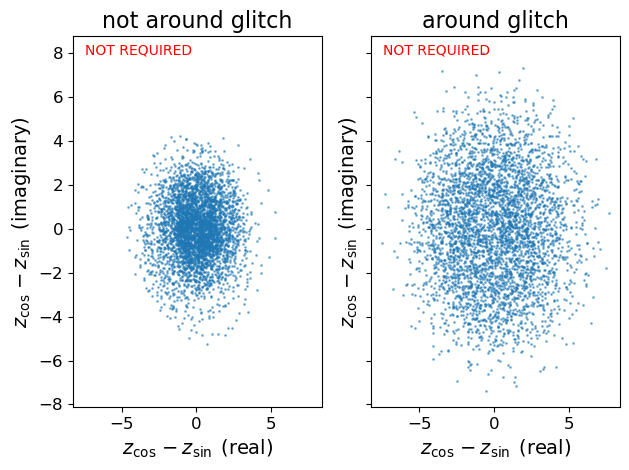

In [26]:
# create 2 scatter plots of z_cos-z_sin (real vs imaginary) around and not around a glitch.
# NOT ASKED FOR IN THE EXAM
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
tslice = slice(*np.searchsorted(times, (100, 101)))
axs[0].scatter(
    (z_low - z_high)[tslice].real,
    (z_low - z_high)[tslice].imag,
    s=1,
    alpha=0.5,
)
axs[0].set_title("not around glitch")
tslice = slice(*np.searchsorted(times, (1258, 1259)))
axs[1].scatter(
    (z_low - z_high)[tslice].real,
    (z_low - z_high)[tslice].imag,
    s=1,
    alpha=0.5,
)
axs[1].set_title("around glitch")
for ax in axs:
    ax.set_xlabel(r"$z_\cos - z_\sin$ (real)")
    ax.set_ylabel(r"$z_\cos - z_\sin$ (imaginary)")
    ax.text(0.05, 0.95, r"NOT REQUIRED", color="red", transform=ax.transAxes)
fig.tight_layout()

In [27]:
glitch_test_statistic = 0.5 * np.abs(z_low - z_high) ** 2
glitch_test_threshold = stats.chi2(df=2).isf(
    0.01
)  # throw away one in a 100 good signals
glitch_mask = (glitch_test_statistic > glitch_test_threshold) * (snr2 > 5**2)

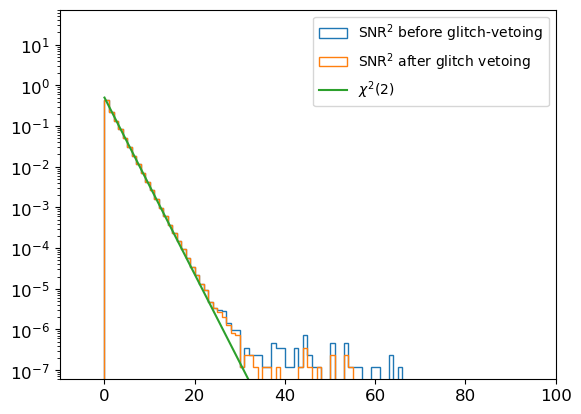

In [28]:
fig, ax = plt.subplots()

hist_kwargs = {
    "histtype": "step",
    "density": True,
    "log": True,
    "bins": range(200),
}
counts, edges, patches = ax.hist(
    snr2, **hist_kwargs, label=r"SNR$^2$ before glitch-vetoing"
)
counts, edges, patches = ax.hist(
    snr2[~glitch_mask], **hist_kwargs, label=r"SNR$^2$ after glitch vetoing"
)


ax.plot(edges, stats.chi2(df=2).pdf(edges), label=r"$\chi^2(2)$")
y_lower_limit = 0.5 / (np.diff(edges).mean() * len(snr2))
ax.set_xlim(right=100)
ax.set_ylim(y_lower_limit)
leg = ax.legend()

# 7

 Now you know how to conduct a search with a single template. We now go on to prepare a bank of templates. The first step is to find a good linear basis to work with. Draw $\sim2^8$ mass samples (see given functions). Create the waveform for each and perform SVD to find their phase basis-vectors. Choose the number of basis-vectors you want to use. **Plot the basis-vectors against frequency**. Make sure to read the guidance before performing the SVD.



In [29]:
m1, m2 = gw_search_functions.draw_mass_samples(2**8)

In [30]:
# take sparser frequency grid
fslice = slice(np.searchsorted(freqs, (fmin)), len(freqs), 128)
fs = freqs[fslice]
phases = np.array(
    [
        gw_search_functions.masses_to_phases(mm1, mm2, fs)
        for mm1, mm2 in zip(m1, m2)
    ]
)

Text(0.75, 0.95, 'NOT REQUIRED')

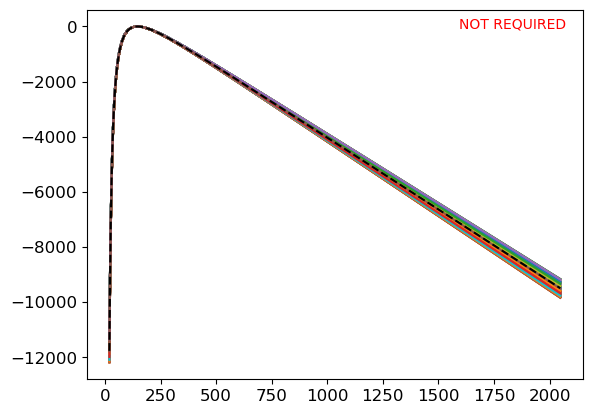

In [31]:
wht_amp = (amp * whitening_filter)[fslice]
wht_amp = wht_amp / np.sqrt(np.sum(wht_amp**2))  # renormalize

linear_free_phases = gw_search_functions.phases_to_linear_free_phases(
    phases, freqs[fslice], weights=wht_amp
)
common_phase_evolution = linear_free_phases.mean(axis=0)
fig, ax = plt.subplots()
ax.plot(freqs[fslice], linear_free_phases.T)
_ = ax.plot(freqs[fslice], common_phase_evolution, ls="--", c="k")
ax.text(0.75, 0.95, r"NOT REQUIRED", color="red", transform=ax.transAxes)

In [32]:
phases_without_common_evolution = linear_free_phases - common_phase_evolution
svd_phase = phases_without_common_evolution
svd_weights = wht_amp
print(svd_weights.shape, svd_phase.shape)


(32449,) (256, 32449)


In [33]:
# could take up to 1-5 minutes.
u, d, v = np.linalg.svd(svd_phase * svd_weights)


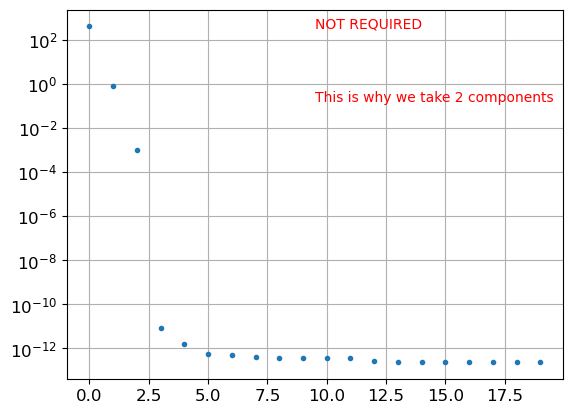

In [34]:
fig, ax = plt.subplots()
ax.semilogy(d[:20], ".")
ax.text(0.5, 0.95, r"NOT REQUIRED", color="red", transform=ax.transAxes)
ax.text(
    0.5,
    0.75,
    r"This is why we take 2 components",
    color="red",
    transform=ax.transAxes,
)
ax.grid()

In [35]:
# check that eignen vectors has zero weighted mean. Meaning, they are orthogonal to a constant function.
(v[0] * svd_weights).mean(), (v[1] * svd_weights).mean()

(np.float64(-1.5762361063663576e-05), np.float64(-9.970148452499374e-06))

In [36]:
output_dir = Path("local_outputs")
if not output_dir.exists():
    output_dir.mkdir()
np.savez(
    output_dir / "GW170817_H_svd", u=u, d=d, v=v, freqs_sliced=fs, freqs=freqs
)

In [37]:
u, d, v = [
    np.load(output_dir / "GW170817_H_svd.npz").get(k) for k in ("u", "d", "v")
]

In [38]:
# pick 2 coordinates
ndim = 2
u = u[:, :ndim]
d = d[:ndim]
v = v[:ndim, :]

# create a phase vector (without weights) from SVD components
# and new set of coordiantes
coordinates = u * d

phase_basis_coarse_freqs = np.zeros_like(v)
mask = svd_weights != 0
phase_basis_coarse_freqs[:, mask] = v[:, mask] / svd_weights[mask]

In [39]:
# normalization tests
print("NOT REQUIRED")
print("SVD weights norm:", np.sum(svd_weights**2))
print(
    "First basis norm:",
    np.sum(svd_weights**2 * phase_basis_coarse_freqs[0] ** 2),
)
print(
    "Const. component in first basis:",
    np.sum(svd_weights**2 * phase_basis_coarse_freqs[1]),
)
print(
    "Second basis norm:",
    np.sum(svd_weights**2 * phase_basis_coarse_freqs[0] ** 2),
)
print(
    "Const. component in second basis:",
    np.sum(svd_weights**2 * phase_basis_coarse_freqs[0]),
)


NOT REQUIRED
SVD weights norm: 1.0
First basis norm: 0.9999999999999911
Const. component in first basis: -0.3235213471351522
Second basis norm: 0.9999999999999911
Const. component in second basis: -0.5114728541548194


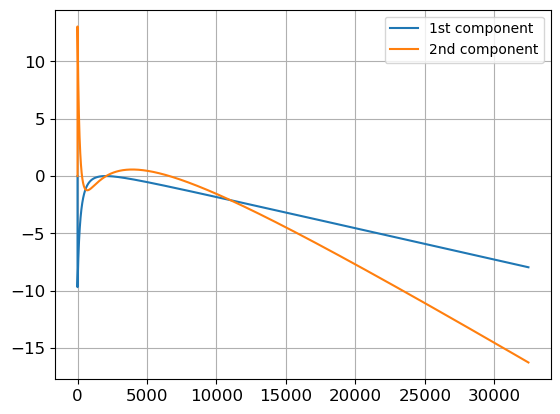

In [40]:
fig, ax = plt.subplots()
ax.plot(phase_basis_coarse_freqs[0], label="1st component")
ax.plot(phase_basis_coarse_freqs[1], label="2nd component")
ax.grid()
leg = ax.legend()


In [41]:
# create full-frequency resolution phase basis
phase_basis = np.array(
    [
        np.interp(x=freqs, xp=freqs[fslice], fp=phase_base, left=0)
        for phase_base in phase_basis_coarse_freqs
    ]
)

##  8

Calculate the inner product between waveforms at different coordinate-distance $\sqrt{\sum_\alpha |\Delta c_\alpha |^2)}$.
**Plot their overlap against their distance, and the theoretical prediction**.

In [42]:
distances = 10 ** np.linspace(-2, 0.5, num=30)
amp = np.zeros_like(freqs[fslice])
cond = whitening_filter[fslice] != 0
amp[cond] = freqs[fslice][cond] ** (-7 / 6)
amp_wht = amp * whitening_filter[fslice]
amp_wht /= np.sqrt(np.sum((amp_wht) ** 2))

matches = np.zeros_like(distances)
for i, distance in enumerate(distances):
    dist_per_coordinate = distance / np.sqrt(2)
    coordinate = np.array([dist_per_coordinate, dist_per_coordinate])
    phase = coordinate @ phase_basis_coarse_freqs + common_phase_evolution
    matches[i] = np.sum(
        amp_wht
        * np.exp(-1j * phase)
        * amp_wht
        * np.exp(+1j * common_phase_evolution)
    ).real

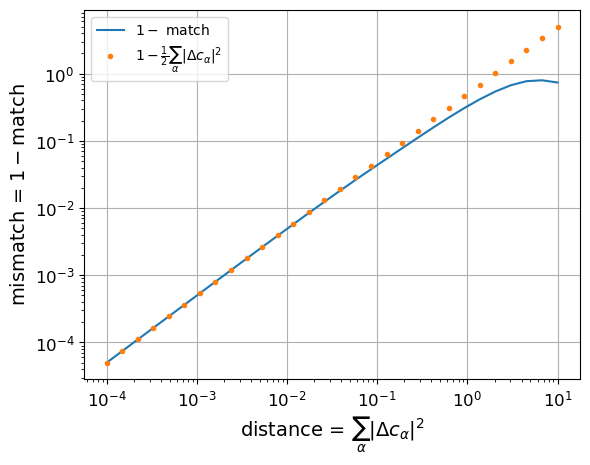

In [43]:
fig, ax = plt.subplots()
ax.loglog(distances**2, 1 - matches, label="$1 - $ match")
ax.loglog(
    distances**2,
    distances**2 / 2,
    ".",
    label=r"$1-\frac{1}{2}\sum_\alpha|\Delta c_\alpha |^2$",
)

ax.set_xlabel(r"distance = $\sum_\alpha |\Delta c_\alpha |^2$")
ax.set_ylabel("mismatch = $1 - $match")
leg = ax.legend(loc="upper left")
ax.grid()

# 9 

Draw $2^{13}$ mass samples. Create the phase for each, and find the coordinates of each.
Select a subset such that the distance between any 2 samples is not smaller than 0.1. 

On the same plot, create a scatter plot of the 213 samples and of the selected subset.
On the plot, write down the size of subset. This subset defines the search bank.

Text(0.5, 0.95, 'NOT REQUIRED')

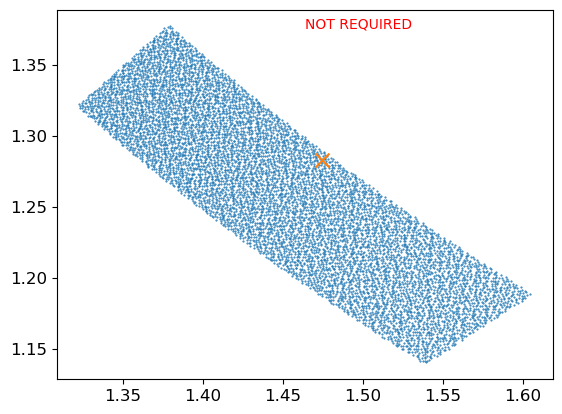

In [44]:
fslice = slice(np.searchsorted(freqs, (fmin)), len(freqs), 128)
freqs_low_res = freqs[fslice]

m1, m2 = gw_search_functions.draw_mass_samples(2**13)
redshift = 0.01
fig, ax = plt.subplots()
ax.scatter(m1, m2, marker=".", s=1)
ax.scatter(1.46 * (1 + redshift), 1.27 * (1 + redshift), s=100, marker="x")
ax.text(0.5, 0.95, r"NOT REQUIRED", color="red", transform=ax.transAxes)

In [45]:
phases_on_coarse_freqs = np.array(
    [
        gw_search_functions.masses_to_phases(mm1, mm2, freqs_low_res)
        for mm1, mm2 in zip(m1, m2)
    ]
)
linear_free_phases = gw_search_functions.phases_to_linear_free_phases(
    phases_on_coarse_freqs, freqs_low_res, amp_wht
)

phases_without_common_evolution = linear_free_phases - common_phase_evolution

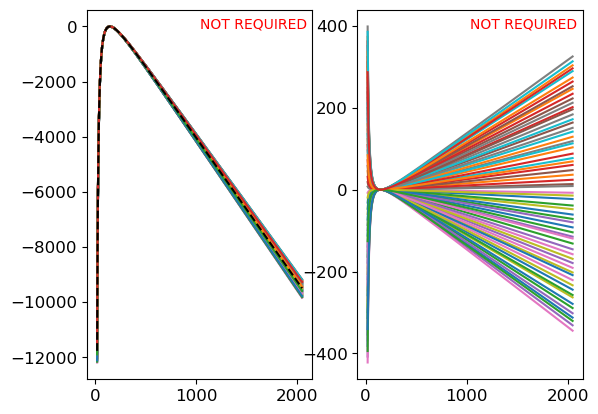

In [46]:
fig, axs = plt.subplots(ncols=2, nrows=1)

axs[0].plot(freqs_low_res, linear_free_phases[:64].T)
axs[0].plot(freqs_low_res, common_phase_evolution, ls="--", c="k")
axs[1].plot(freqs_low_res, phases_without_common_evolution[:64].T)
for ax in axs:
    ax.text(0.5, 0.95, r"NOT REQUIRED", color="red", transform=ax.transAxes)


In [47]:
coordinates = (
    svd_weights**2 * phases_without_common_evolution
) @ phase_basis_coarse_freqs.T

bank_coordinates, bank_indices = (
    gw_search_functions.select_points_without_clutter(
        coordinates, np.sqrt(0.1)
    )
)

(213, 2)


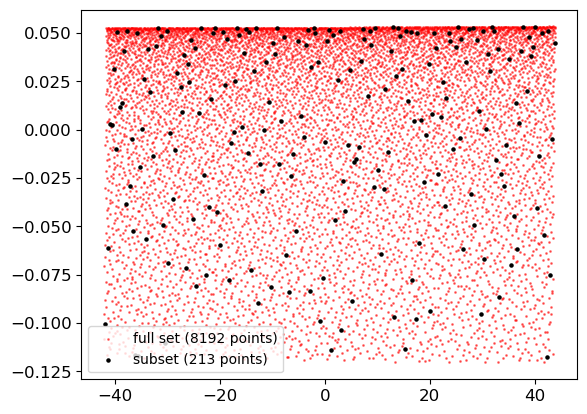

In [48]:
plt.scatter(
    *coordinates.T,
    s=1,
    alpha=0.5,
    c="r",
    label=f"full set ({len(coordinates)} points)",
)
plt.scatter(
    *bank_coordinates.T,
    s=5,
    c="k",
    label=f"subset ({len(bank_coordinates)} points)",
)
print(bank_coordinates.shape)
plt.legend()

In [49]:
amp = np.zeros_like(freqs)
amp[i1:] = freqs[i1:] ** (-7 / 6)
normalization = gw_search_functions.correlate(amp, amp, w=whitening_filter)[
    0
] ** (1 / 2)
amp /= normalization

# 10

Repeat the search (sections 4-6, without repeating their plots) for each template in the bank individually (including glitch-removal). For each interval of 0.1 seconds, record which template gave the maximal SNR, and what was that SNR. **Plot the time-series of maximal SNR$^2$ in per 0.1 seconds. Plot a histogram of the maximal values per 0.1 seconds**. *Before using the entire bank, try a small subset and see that the results make sense. The entire search could take several minutes, depending on hardware*.

In [50]:
indices_lists = []
snr2_lists = []
min_snr2_to_save = stats.chi2(df=2).isf(1 / (times[-1] / 0.1))
glitch_test_threshold = stats.chi2(df=2).isf(0.01)
snr2_lists_raw = []
indices_lists_raw = []
glitch_mask_list = []
common_phase_evolution_high_res = np.interp(
    x=freqs, xp=freqs_low_res, fp=common_phase_evolution
)
fs = 1 / dt
t_start = time.time()

for template_index, template_coordinate in tqdm(
    enumerate(bank_coordinates), total=len(bank_coordinates), desc="template"
):
    phase = common_phase_evolution_high_res + template_coordinate @ phase_basis
    h = amp * np.exp(1j * phase)

    snr2 = gw_search_functions.snr2_timeseries(
        h * whitening_filter, strain_f * whitening_filter
    )
    h_low, h_high = np.zeros((2, len(freqs)), complex)
    h_low[:i_fbar] = h[:i_fbar]
    h_high[i_fbar:] = h[i_fbar:]
    z_low = gw_search_functions.complex_overlap_timeseries(
        h_low * whitening_filter, strain_f * whitening_filter
    )
    z_high = gw_search_functions.complex_overlap_timeseries(
        h_high * whitening_filter, strain_f * whitening_filter
    )

    glitch_test_statistic = np.abs(z_low - z_high) ** 2

    glitch_mask = (glitch_test_statistic > glitch_test_threshold) * (snr2 > 10)
    glitch_mask_list.append(glitch_mask)
    maxs, argmaxs = gw_search_functions.max_argmax_over_n_samples(
        snr2 * ~glitch_mask, int(0.1 * fs)
    )
    indices_lists.append(argmaxs)
    snr2_lists.append(maxs)

    maxs, argmaxs = gw_search_functions.max_argmax_over_n_samples(
        snr2, int(0.1 * fs)
    )
    indices_lists_raw.append(argmaxs)
    snr2_lists_raw.append(maxs)

snr2_per_template = np.array(snr2_lists)
time_indices_per_template = np.array(indices_lists)
snr2_per_template_with_glitches = np.array(snr2_lists_raw)

print("Done!")

template: 100%|██████████| 213/213 [03:31<00:00,  1.01it/s]

Done!


In [51]:
time_bins = np.linspace(0, times[-1], snr2_per_template.shape[1])


Text(0, 0.5, 'Bestfit ${\\rm SNR}^2$')

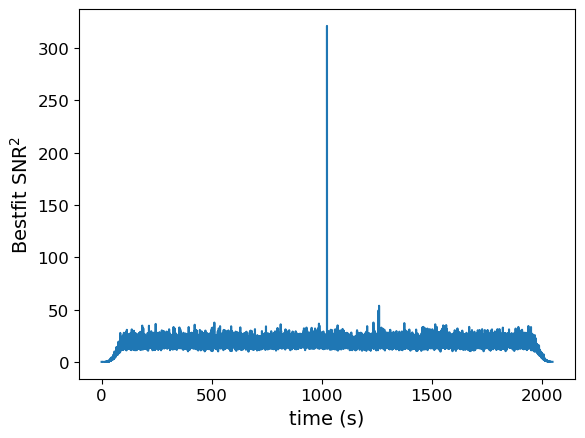

In [52]:
fig, ax = plt.subplots()
ax.plot(time_bins, snr2_per_template.max(axis=0))
ax.set_xlabel("time (s)")
ax.set_ylabel(r"Bestfit ${\rm SNR}^2$")

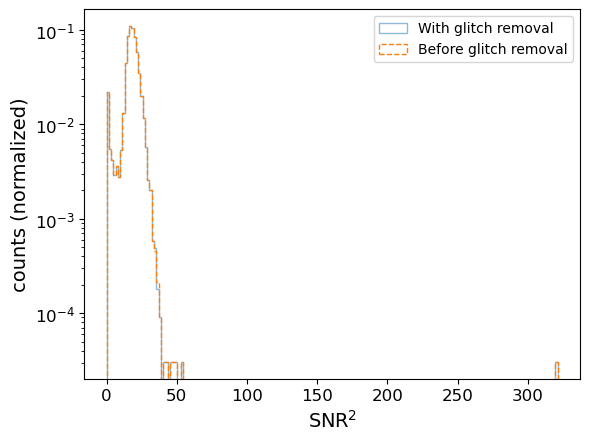

In [53]:
fig, ax = plt.subplots()
hist_kwargs = {"histtype": "step", "density": True, "log": True, "bins": 200}
counts, edges, patches = ax.hist(
    snr2_per_template.max(axis=0),
    **hist_kwargs,
    alpha=0.5,
    label="With glitch removal",
)

hist_kwargs = {"histtype": "step", "density": True, "log": True, "bins": 200}
counts, edges, patches = ax.hist(
    snr2_per_template_with_glitches.max(axis=0).flatten(),
    label="Before glitch removal",
    **hist_kwargs,
    ls="--",
)

ax.set_xlabel(r"${\rm SNR}^2$")
ax.set_ylabel("counts (normalized)")
leg = ax.legend()


## 11.
If you detected an event, **report its time, the masses of the template and an estimation or a upper bound of the false-alarm rate for such SNR**. Consider the number of templates you used and the fact that waveforms have typical auto-correlation length of 1 ms.

In [54]:
# compare with https://arxiv.org/pdf/1710.05832 Table 1
best_template_index, best_timestamp_index = np.unravel_index(
    snr2_per_template.argmax(), snr2_per_template.shape
)
bestfit_m1 = m1[best_template_index]
bestfit_m2 = m2[best_template_index]
bestfit_mchirp = gw_search_functions.m1m2_to_mchirp(bestfit_m1, bestfit_m2)
bestfit_snr2 = snr2_per_template.max()
time_bins = np.linspace(0, times[-1], snr2_per_template.shape[1])
bestfit_time = snr2_per_template.max(axis=0).argmax()

print("NOT REQUIRED")
print(f"Maximal SNR^2 found : {bestfit_snr2:.5g} at time {bestfit_time:.3g}")
print(
    f"Template of masses ({bestfit_m1:.3g},{bestfit_m2:.3g}), or chirp-mass {bestfit_mchirp:.5g} (solar masses)"
)

NOT REQUIRED
Maximal SNR^2 found : 321.21 at time 1.03e+04
Template of masses (1.43,1.32), or chirp-mass 1.1979 (solar masses)



p = Probability that non of N = N_templates * N_times individual experiments will reach value x or higher :
$$p = 1 - (SF(x))^N$$

Probability that at least one of $N$ experiments will reach value x:
$1 - p = (SF(x))^N $

At this high SNR^2, the FAR is almost exactly zero


In [55]:
N_templates = bank_coordinates.shape[0]
N_trials = N_templates * len(times)

stats.chi2(df=2).sf(snr2_per_template.max()) ** N_trials

np.float64(0.0)

In [56]:
np.log(1 - stats.chi2(df).sf(snr2_per_template.max()))

np.float64(0.0)

use binomial to imporve the calculation

$$ FAR = 1 - CDF(x)^N = 1 - (1-SF(x))^N \approx 1 - 1 + N\cdot SF(x) = N\cdot SF(x) $$

In [57]:
snr2_per_template.size * stats.chi2(df=2).sf(snr2_per_template.max())

np.float64(7.782002189347895e-64)

## 12.

**Create a spectogram (using e.g. `matplotlib.pyplot.specgram`), localized in time and frequency around the event you found**.

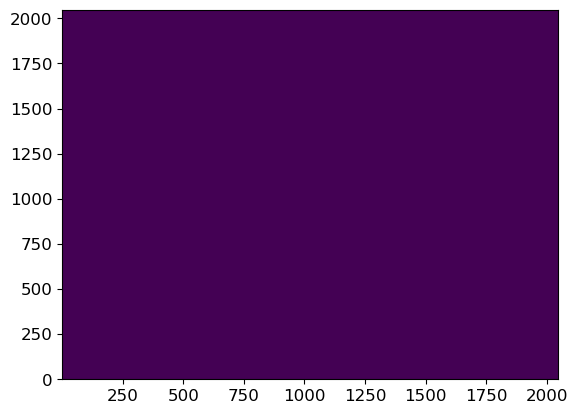

In [58]:
# create the histogram in 2 steps. So I can calibrate the dynamic range in the second histogram using the fist histogram
specgram_kwargs = {
    "x": np.fft.irfft(strain_f * whitening_filter),
    "NFFT": int(fs * 0.5),
    "noverlap": int(fs * 0.25),
    "scale": "linear",
    "vmin": 0,
    "vmax": 25,
    "Fs": fs,
}

o = plt.specgram(**specgram_kwargs)

(20.0, 1000.0)

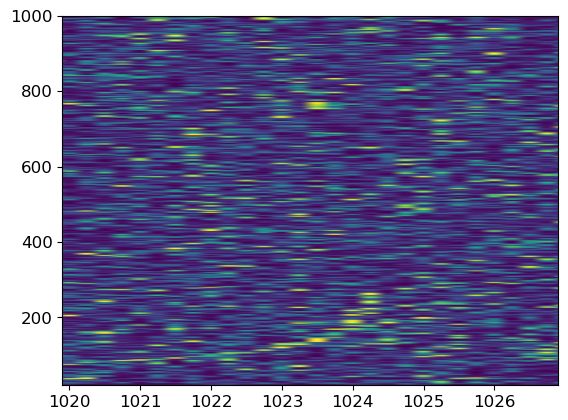

In [59]:
specgram_kwargs = {
    "x": np.fft.irfft(strain_f * whitening_filter),
    "NFFT": int(fs * 0.5),
    "noverlap": int(fs * 0.25),
    "scale": "linear",
    "vmin": 0,
    "vmax": o[0][(o[1] > 20) * (o[1] < 1000)].std() * 5,
    "Fs": fs,
}

o = plt.specgram(**specgram_kwargs)
tmin = 0.1 * 10259 - 6
tmax = 0.1 * 10259 + 1
fmin = 20
fmax = 1000
plt.xlim(tmin, tmax)
plt.ylim(20, 1000)

In [60]:
TIME1 = time.time()

print(f"Time passed: {TIME1 - TIME0:.3g} seconds")

Time passed: 298 seconds
